In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through the video folders
        for video_folder in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, video_folder)):
                video_path = os.path.join(root_dir, video_folder) #dataset/AM12
                #label_file = os.path.join(root_dir, 'labels', f'{video_folder}.xlsx') #dataset/labels/AM12.xlsx
                label_file = os.path.join('/content/drive/MyDrive/DSI Scholar ', 'labels', f'{video_folder}.xlsx')
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):  #video_path = dataset/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename) #dataset/AM12/0.jpg
                        frame_idx = int(os.path.splitext(img_filename)[0]) #splitting 0.jpg and storing 0 to frame_idx
                        labels = labels_df.iloc[frame_idx, 1:].values.astype('float32')

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create instances of custom dataset for train, validation, and test
train_dataset = CustomDataset('/content/drive/MyDrive/DSI Scholar /dataset', transform=transform) #/Users/ritvikkhandelwal/Desktop/DSI scholar code /dataset
#valid_dataset = CustomDataset('path_to_dataset_folder/validation', transform=transform)
#test_dataset = CustomDataset('path_to_dataset_folder/test', transform=transform)

# Create data loaders
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#checking if data has been loaded correctly
for image, labels in train_dataset:
    print("Image Shape:", image.shape)
    print("Labels:", labels)

Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 1. 0.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: torch.Size([3, 224, 224])
Labels: [0. 0. 1.]
Image Shape: t

KeyboardInterrupt: ignored

In [ ]:
len(train_dataset)

1407

In [ ]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print("Batch Index:", batch_idx)
    print("Image Batch Shape:", images.shape)
    print("Labels Batch Shape:", labels.shape)

Batch Index: 0
Image Batch Shape: torch.Size([32, 3, 224, 224])
Labels Batch Shape: torch.Size([32, 3])
Batch Index: 1
Image Batch Shape: torch.Size([32, 3, 224, 224])
Labels Batch Shape: torch.Size([32, 3])
Batch Index: 2
Image Batch Shape: torch.Size([32, 3, 224, 224])
Labels Batch Shape: torch.Size([32, 3])


KeyboardInterrupt: ignored

In [ ]:
from torch.utils.data import random_split

# Define the sizes for training, validation, and test sets
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(train_size) #1269
print(val_size)   #158
print(test_size)  #160

1125
140
142


In [ ]:
# Use random_split to split the dataset
train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

# Create data loaders for each subset
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


In [ ]:
print(len(train_subset))

1125


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

36
5
5


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Define a custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize the model and move it to the GPU
num_classes = 3  # Number of labels
model = CustomResNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a loss function (e.g., Binary Cross-Entropy) and an optimizer (e.g., Adam)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load your training and test datasets (assuming you've already created DataLoader instances)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 5  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    # Initialize the progress bar
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False)
    # Initialize loss and accuracy variables for this epoch
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate the running loss and accuracy
        running_loss += loss.item()
        predicted_labels = (outputs > 0.5).int()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

        # Update the progress bar with the loss and accuracy
        train_progress_bar.set_postfix(loss=running_loss / (train_progress_bar.n + 1), accuracy=correct_predictions / total_samples)

    # Print epoch statistics
    print(f'Epoch {epoch + 1} - Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct_predictions / total_samples:.2f}%')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1:   0%|          | 0/36 [00:10<?, ?it/s, accuracy=2.78, loss=8.71]

Epoch 1 - Loss: 0.2420, Accuracy: 278.31%




Epoch 2:   0%|          | 0/36 [00:10<?, ?it/s, accuracy=2.93, loss=2.54]

Epoch 2 - Loss: 0.0705, Accuracy: 292.89%


Epoch 3:   0%|          | 0/36 [00:09<?, ?it/s, accuracy=2.96, loss=1.49]

Epoch 3 - Loss: 0.0414, Accuracy: 295.56%




Epoch 4:   0%|          | 0/36 [00:11<?, ?it/s, accuracy=2.96, loss=1.54]

Epoch 4 - Loss: 0.0429, Accuracy: 295.73%


Epoch 5:   0%|          | 0/36 [00:10<?, ?it/s, accuracy=2.97, loss=1.23]

Epoch 5 - Loss: 0.0341, Accuracy: 296.89%


In [ ]:
# Evaluation loop on the test dataset
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels along the batch dimension
import numpy as np
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Threshold predictions (assuming a threshold of 0.5)
all_preds = (all_preds > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='samples')
recall = recall_score(all_labels, all_preds, average='samples')
f1 = f1_score(all_labels, all_preds, average='samples')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.9366197183098591
Precision: 0.926056338028169
Recall: 0.9295774647887324
F1-Score: 0.927230046948357


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
print(all_preds[30:40])
print(all_labels[30:40])

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 0]]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
non_identical_indices = []

# Iterate through the arrays and compare their elements
for i in range(len(all_labels)):
    if not np.array_equal(all_labels[i], all_preds[i]):
        non_identical_indices.append(i)

# Print the indices of non-identical elements
print("Indices of non-identical elements:", non_identical_indices)

Indices of non-identical elements: [3, 13, 71, 107, 109, 111, 114, 128, 134]


In [ ]:
# Display the non-identical elements
for idx in non_identical_indices:
    print("Element at index", idx, "in all_labels:", all_labels[idx])
    print("Element at index", idx, "in all_preds:", all_preds[idx])
    print("")

Element at index 3 in all_labels: [0. 0. 1.]
Element at index 3 in all_preds: [0 0 0]

Element at index 13 in all_labels: [1. 0. 0.]
Element at index 13 in all_preds: [0 1 0]

Element at index 71 in all_labels: [0. 0. 1.]
Element at index 71 in all_preds: [0 0 0]

Element at index 107 in all_labels: [0. 0. 1.]
Element at index 107 in all_preds: [0 1 1]

Element at index 109 in all_labels: [0. 0. 1.]
Element at index 109 in all_preds: [0 0 0]

Element at index 111 in all_labels: [0. 0. 1.]
Element at index 111 in all_preds: [0 0 0]

Element at index 114 in all_labels: [1. 0. 0.]
Element at index 114 in all_preds: [0 1 0]

Element at index 128 in all_labels: [1. 0. 0.]
Element at index 128 in all_preds: [0 0 0]

Element at index 134 in all_labels: [1. 0. 0.]
Element at index 134 in all_preds: [0 1 0]



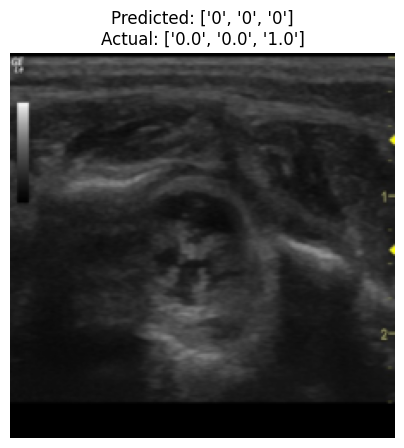

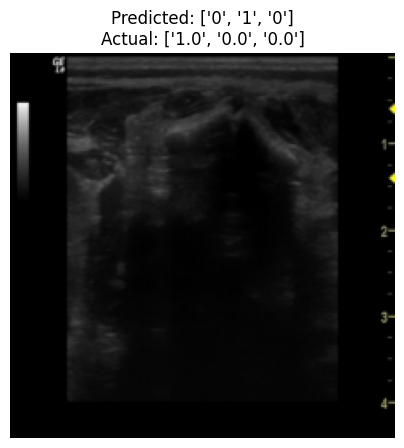

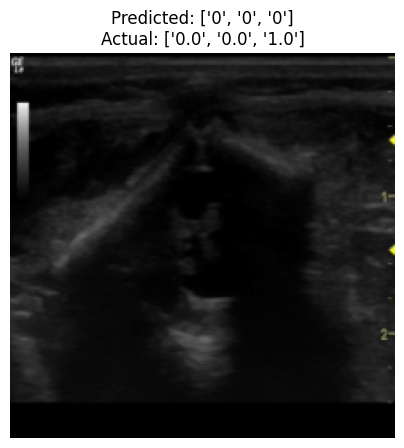

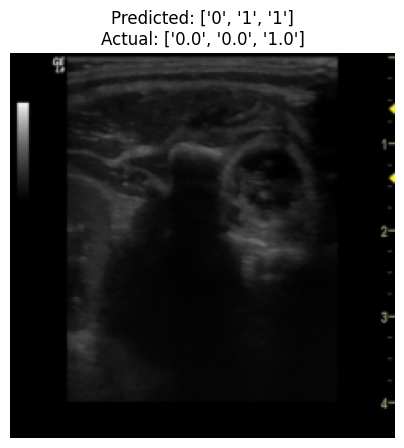

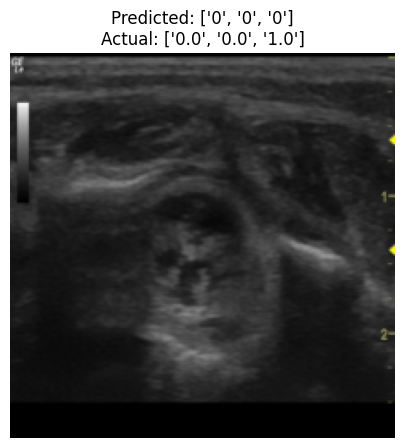

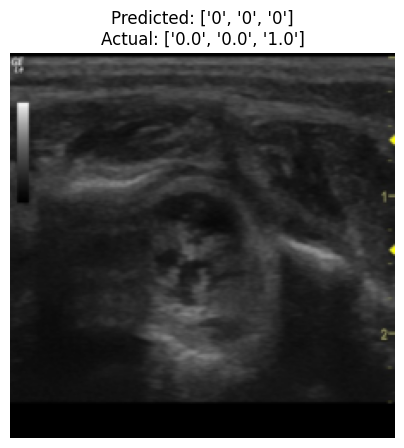

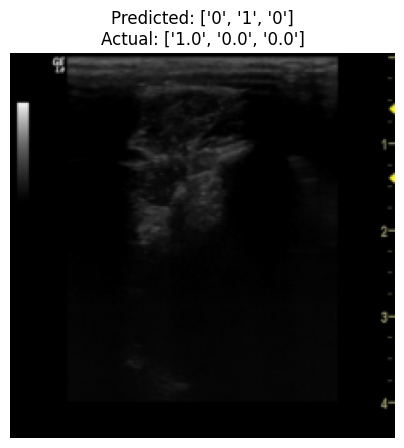

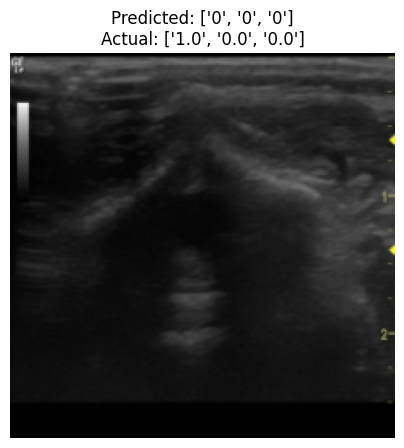

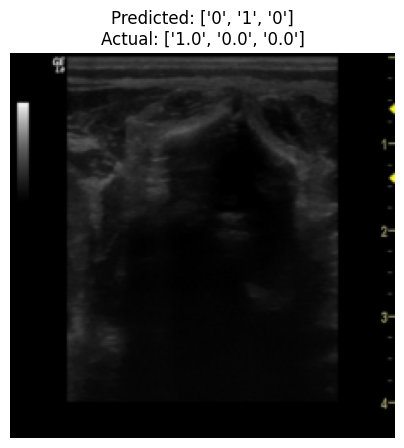

In [ ]:
import matplotlib.pyplot as plt

model.eval()
misclassified_images = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).int()

        for j in range(images.size(0)):
            if not torch.equal(preds[j], labels[j]):
                # Append the misclassified image along with its predicted and actual labels
                misclassified_images.append((images[j], preds[j], labels[j]))

# Display misclassified images
for i, (image, predicted_labels, actual_labels) in enumerate(misclassified_images):
    # Assuming you have a function to convert labels to their actual names
    predicted_labels = [str(label.item()) for label in predicted_labels]
    actual_labels = [str(label.item()) for label in actual_labels]

    # Display the image along with predicted and actual labels
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1, 2, 0).cpu())  # Assuming your images are in CHW format
    plt.title(f"Predicted: {predicted_labels}\nActual: {actual_labels}")
    plt.axis('off')
    plt.show()


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = (np.vstack(all_preds) > 0.5).astype(int)
all_labels = np.vstack(all_labels)

# Calculate the multilabel confusion matrix
confusion_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
for i, label in enumerate(confusion_matrix):
    print(f"Confusion Matrix for Label {i}:\n{label}")


Confusion Matrix for Label 0:
[[123   0]
 [  4  15]]
Confusion Matrix for Label 1:
[[97  4]
 [ 0 41]]
Confusion Matrix for Label 2:
[[62  0]
 [ 4 76]]


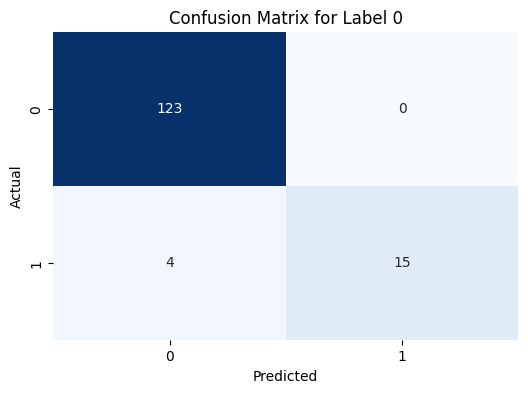

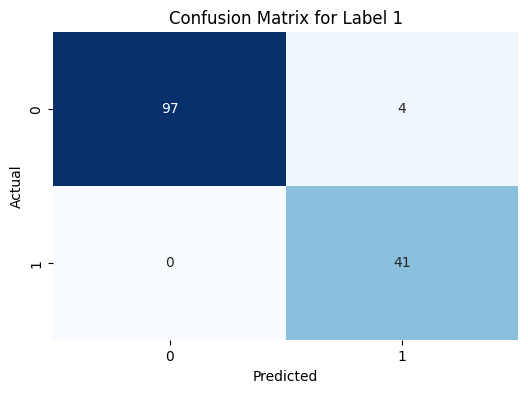

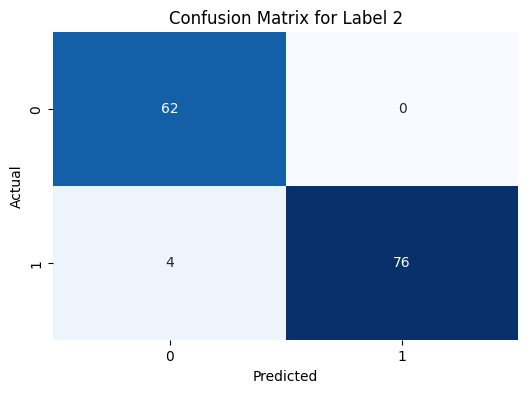

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = (np.vstack(all_preds) > 0.5).astype(int)
all_labels = np.vstack(all_labels)

# Calculate the multilabel confusion matrix
confusion_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Create a heatmap for each label's confusion matrix
for i, label in enumerate(confusion_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(label, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for Label {i}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have the multilabel confusion matrix stored in `confusion_matrix`

label_metrics = []

for i, label in enumerate(confusion_matrix):
    tn, fp, fn, tp = label.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    label_metrics.append({
        "Label": i,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    })

# Display metrics for each label
for metric in label_metrics:
    print(f"Label {metric['Label']}:")
    print(f"Accuracy: {metric['Accuracy']:.2f}")
    print(f"Precision: {metric['Precision']:.2f}")
    print(f"Recall: {metric['Recall']:.2f}")
    print(f"F1-Score: {metric['F1-Score']:.2f}")
    print()


Label 0:
Accuracy: 0.97
Precision: 1.00
Recall: 0.79
F1-Score: 0.88

Label 1:
Accuracy: 0.97
Precision: 0.91
Recall: 1.00
F1-Score: 0.95

Label 2:
Accuracy: 0.97
Precision: 1.00
Recall: 0.95
F1-Score: 0.97



In [ ]:
#need sensitivity and specificity